# Survival analysis 

In [45]:
#for maths
import numpy as np
#for data manipulation
import pandas as pd

#for dataviz 
from matplotlib import pyplot as plt 

### Lifelines library 
Python library for survival analysis studies 

In [2]:
#pip install lifelines 

## Schoenfeld residuals : 
method to check cox model assumptions : 
  - common baseline hazard 
  - covariant X invariant over time 
  - beta coefficients invariant over time 


we will use a stanford heart transplant dataset to demonstrate it 

In [3]:
stanford_data = pd.read_csv("stanford_heart_transplant_dataset_full.csv")
stanford_data.sample(5)

,PATIENT_ID,YR_OF_ACCEPTANCE,AGE,SURVIVAL_STATUS,SURVIVAL_TIME,PRIOR_SURGERY,TRANSPLANT_STATUS,WAITING_TIME_FOR_TRANSPLANT,MISMATCH_ON_ALLELES,MISMATCH_ON_ANTIGEN,MISMATCH_SCORE
80,78,72,48,0,515,0,1,210.0,3.0,0.0,0.81
95,49,71,36,0,1141,1,1,36.0,4.0,0.0,1.35
76,86,73,48,0,397,0,1,8.0,3.0,1.0,1.44
43,62,71,39,1,69,0,0,NaN,NaN,NaN,NaN
50,9,68,47,1,85,0,0,NaN,NaN,NaN,NaN


In [4]:
stanford_data.columns

Index(['PATIENT_ID', 'YR_OF_ACCEPTANCE', 'AGE', 'SURVIVAL_STATUS',
       'SURVIVAL_TIME', 'PRIOR_SURGERY', 'TRANSPLANT_STATUS',
       'WAITING_TIME_FOR_TRANSPLANT', 'MISMATCH_ON_ALLELES',
       'MISMATCH_ON_ANTIGEN', 'MISMATCH_SCORE'],
      dtype='object')

### lets consider our variables : 
  - Response variables (y) : SURVIVAL_TIME and SURVIVAL_STATUS
  - Regression matrix variables (X) : AGE , PRIOR_SURGERY (patient received an open heart surgery before ? ), TRANSPLANT_STATUS (whether patient received transplant during study)
  

lets get these columns as our needed dataframe 

In [5]:
study_df = stanford_data[['AGE', 'PRIOR_SURGERY', 'TRANSPLANT_STATUS', 'SURVIVAL_TIME','SURVIVAL_STATUS']].copy()
study_df.head()

,AGE,PRIOR_SURGERY,TRANSPLANT_STATUS,SURVIVAL_TIME,SURVIVAL_STATUS
0,53,0,0,1,1
1,43,0,0,2,1
2,52,0,0,2,1
3,52,0,0,2,1
4,54,0,0,3,1


### Import the COX PH fitter from the lifelines library

In [6]:
from lifelines import CoxPHFitter

Create and train the Cox Model on our training set 

In [7]:
#create the coxphfitter
mycph_model = CoxPHFitter()

#fit it to our training set 
mycph_model.fit(df = study_df, duration_col = 'SURVIVAL_TIME' ,
event_col = 'SURVIVAL_STATUS')


<lifelines.CoxPHFitter: fitted with 103 total observations, 28 right-censored observations>

lets display the model summary

In [8]:
mycph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 103 total observations, 28 right-censored observations>
             duration col = 'SURVIVAL_TIME'
                event col = 'SURVIVAL_STATUS'
      baseline estimation = breslow
   number of observations = 103
number of events observed = 75
   partial log-likelihood = -274.18
         time fit was run = 2023-07-08 00:11:33 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
AGE                 0.06       1.06       0.01             0.03             0.09                 1.03                 1.09
PRIOR_SURGERY      -0.74       0.48       0.44            -1.61             0.12                 0.20                 1.13
TRANSPLANT_STATUS  -1.66       0.19       0.28            -2.20            -1.12                 0.11                 0.33

                    cmp to     z      p   -log2(p)
covariate                                         
AGE                   0.00  3.96 <0.005      13.71
PRIOR_SURGERY         0.00 -1.68   0.09       3.43
TRANSPLANT_STATUS     0.00 -6.02 <0.005      29.11
---
Concordance = 0.74
Partial AIC = 554.35
log-likelihood ratio test = 47.89 on 3 df
-log2(p) of ll-ratio test = 32.05

Schoenfeld residuals are calculated for each regression variable separately 

lets start with the Age variable 

In [17]:
#status 1 -> dead
study_df[study_df.SURVIVAL_STATUS == 1]

,AGE,PRIOR_SURGERY,TRANSPLANT_STATUS,SURVIVAL_TIME,SURVIVAL_STATUS
0,53,0,0,1,1
1,43,0,0,2,1
2,52,0,0,2,1
3,52,0,0,2,1
4,54,0,0,3,1
...,...,...,...,...,...
89,44,0,1,852,1
92,45,1,1,979,1
93,48,1,1,995,1
94,43,0,1,1032,1


In [20]:
study_df.head(24)

,AGE,PRIOR_SURGERY,TRANSPLANT_STATUS,SURVIVAL_TIME,SURVIVAL_STATUS
0,53,0,0,1,1
1,43,0,0,2,1
2,52,0,0,2,1
3,52,0,0,2,1
4,54,0,0,3,1
5,36,0,0,3,1
6,47,0,0,3,1
7,41,0,1,5,1
8,47,0,0,5,1
9,51,0,0,6,1


lets focus on the first month after the beggining of our study , we notice a death of the 23rd patient on the 30th day 

lets get the at-risk column at T=30 to check our cox model assumptions

In [22]:
#since its on the 23th line , every patient after is at an 'at risk' status 
X30 = np.array(study_df[['AGE', 'PRIOR_SURGERY', 'TRANSPLANT_STATUS']])[23:,]

### At risk patients after a month of study

In [24]:
X30 

array([[52,  0,  1],
       [49,  0,  0],
       [53,  0,  0],
       [50,  0,  0],
       [20,  0,  0],
       [59,  0,  0],
       [40,  0,  1],
       [35,  1,  1],
       [45,  0,  0],
       [42,  0,  0],
       [56,  0,  1],
       [36,  0,  1],
       [30,  0,  0],
       [42,  0,  1],
       [50,  0,  1],
       [42,  0,  1],
       [52,  0,  1],
       [61,  0,  1],
       [45,  0,  1],
       [49,  0,  1],
       [39,  0,  0],
       [53,  0,  1],
       [47,  0,  1],
       [64,  0,  1],
       [51,  0,  1],
       [53,  0,  1],
       [54,  0,  1],
       [47,  0,  0],
       [56,  0,  1],
       [53,  0,  1],
       [48,  0,  1],
       [41,  0,  0],
       [28,  0,  1],
       [46,  0,  1],
       [23,  0,  1],
       [41,  0,  0],
       [47,  0,  1],
       [43,  1,  1],
       [26,  0,  1],
       [52,  1,  1],
       [47,  0,  1],
       [51,  0,  1],
       [51,  0,  1],
       [ 8,  0,  0],
       [47,  0,  1],
       [48,  0,  1],
       [19,  0,  1],
       [49,  

lets focus on the first column (age) and check its expected value : 

the expected age of the people who are at risk of dying after 30 days 

Expected value = sigma(sum) over values in R30 (value * proba of dying knowing at risk at 30th day )

In [28]:
#get beta coefficients
Beta = np.array(mycph_model.params_).reshape(-1,1)

In [31]:
#get the expos * betas 
exp_X30_beta = np.exp(np.matmul(X30, Beta))


In [32]:
#get the sums of expos betas 
sum_exp_X30_beta = np.sum(exp_X30_beta)

In [33]:
#get the Cox probabilties of a person dying at day 30th 
probaCox = exp_X30_beta/sum_exp_X30_beta

In [37]:
#get only age column (column 0)
X30_age = X30[:,0].reshape(1,-1)


In [38]:
#compute expected age at R30
expected_age_X30 = np.matmul(X30_age, probaCox)

print('Expected age of patients in R30 = ' + str(expected_age_X30))    

Expected age of patients in R30 = [[47.83197976]]


In [41]:
#substact expected age from observed age 
schoenfeldResiduals = X30_age - expected_age_X30



the value of the schoenfeld residual for the covariate Age at day 30 is actually the mean of the schoenfeld residuals vector 

In [42]:
mean_schoenfeldResiduals = np.mean(schoenfeldResiduals)
mean_schoenfeldResiduals

-3.4694797614358395

in practise we would have to do what we just did for each regression variable for each T__i where an event of interest occurs, and put the results in a schoenfeld residuals time series for each variable , but fortunately we got libraries that do the work for us

also we often scale schoenfeld residuals using their variance

### Checking Cox assumptions using schoenfeld residuals 

In [43]:
scaled_schoenfeld_residuals = mycph_model.compute_residuals(training_dataframe= study_df,
kind = 'scaled_schoenfeld')
print(scaled_schoenfeld_residuals)

covariate       AGE  PRIOR_SURGERY  TRANSPLANT_STATUS
0          0.108016       0.238234          -2.080046
1         -0.054060       0.109209          -1.038217
2          0.096612       0.237691          -2.084436
3          0.096612       0.237691          -2.084436
4          0.134923       0.283896          -2.473656
..              ...            ...                ...
89         0.009017      -3.239803           1.182428
92         0.031107      10.614332          -0.401928
93         0.082979      11.219455          -0.771960
94        -0.009399      -2.763064           1.602164
97         0.154845      -1.657014           0.640058

[75 rows x 3 columns]


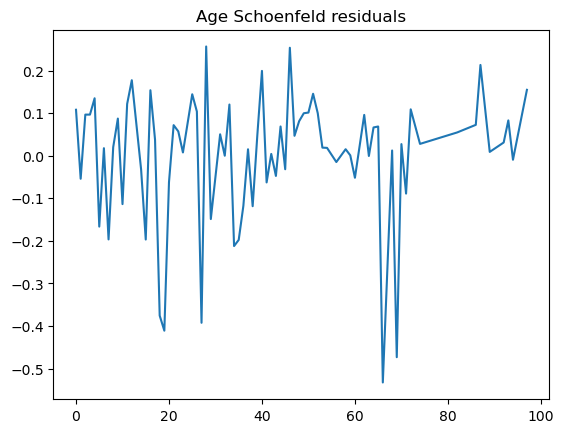

In [47]:
#lets plot the Age schoenfeld residuals 
plt.plot(scaled_schoenfeld_residuals.index, scaled_schoenfeld_residuals['AGE'])
plt.title('Age Schoenfeld residuals')
plt.show()

### To check that there's no time based pattern: 
 - plot the Ljung-Box and box pierce tests to see if we get anything more than white noise 

we will use the statsmodels library 

In [48]:
import statsmodels.stats.diagnostic as diag 

diag.acorr_ljungbox(x= scaled_schoenfeld_residuals['AGE'], lags=[40],
                    boxpierce = True , model_df = 0, period = None, return_df = None)



(array([39.18080838]),
 array([0.50696947]),
 array([26.42444177]),
 array([0.95127985]))

We notice that both the p value for the ljungbox test (0.50696947) and box pierce test (0.95127985)
are much greater than 0.05 , which supports our null hypothesis , we conclude that there s no time based pattern in the schoenfeld residuals for Age 

lets run the tests for the other variables : 

In [49]:
diag.acorr_ljungbox(x= scaled_schoenfeld_residuals['PRIOR_SURGERY'], lags=[40],
                    boxpierce = True , model_df = 0, period = None, return_df = None)

(array([54.23449056]),
 array([0.06592408]),
 array([45.71670751]),
 array([0.24673926]))

In [50]:
diag.acorr_ljungbox(x= scaled_schoenfeld_residuals['TRANSPLANT_STATUS'], lags=[40],
                    boxpierce = True , model_df = 0, period = None, return_df = None)

(array([24.68047734]),
 array([0.97266311]),
 array([15.81377997]),
 array([0.99978178]))

we notice that the p values for our 3 variables are greater than 0.05, so the schoenfeld residuals are not auto correlated 